# Plugin Estimator
This notebook we write code for a method to benchmark our random forest estimate against.
We will be using the plugin estimator where we measure the parameters assuming we already know the distributions of X and Y.

## Sampling Code

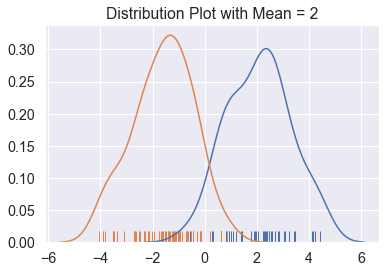

In [6]:
import numpy as np
%matplotlib inline
# NOTE: we are storing y's as 1's or 0's but still doing the mean stuff correctly
def get_sample(n, mean, var):
    x_sample = []
    y_sample = []
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.normal(-mean, var)
        else:
            x = np.random.normal(mean, var)
        x_sample.append(x)
        y_sample.append(y)
    return x_sample, y_sample

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)

def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_sample(100, 2, 1)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
sns.distplot(list(zip(*class_one))[0], hist=False, rug=True)
sns.distplot(list(zip(*class_neg_one))[0], hist=False, rug=True)
plt.title("Distribution Plot with Mean = 2")
plt.show()

We copy below the math needed to solve for H(Y|X) below:
    
We will do the same math as above to calculate the true conditional entropy when $\mu = 1$. The math is actually very clean! $H(Y)$ is still the same.

$H(X) = -\int_x (\frac{1}{2}\mathcal N(1, 1) + \frac{1}{2}\mathcal N(-1, 1))\log (\frac{1}{2}\mathcal N(1, 1) + \frac{1}{2}\mathcal N(-1, 1)) dx$  

This is messy... BUT notice that $\mathcal N(1, 1)$ and $\mathcal N(-1, 1)$ are just mirrors of each other! Besides the different means, the distributions are completely the same. So if we distribute the first summation we should get two identical "entropies"! (I did this numerically in wolfram alpha as well just to make sure).  

$H(X) = -2(\int_x \frac{1}{2}\mathcal N(1, 1) log (\frac{1}{2}\mathcal N(1, 1) + \frac{1}{2}\mathcal N(-1, 1))dx = 1.75577$  

Now for $H(X|Y)$ . 

$H(X|Y) = \frac{1}{2} H(X|Y = 1) + \frac{1}{2} H(X| Y = -1)$ . 

Again we use the fact that $H(X|Y = 1) == H(X|Y = -1)$  

So, $H(X|Y) = \int_x \mathcal N(1, 1)\log \mathcal N(1, 1) dx = 1.41894$  

So $I(X, Y) = .33683$. $H(Y|X) = .356316$

In general, we need to approximate the parameters of the distributions of X and Y.
For distribution of Y, Y is just Bernoulli (multinomial if k sample). So the MLE estimate of p hat is just n/N, where n is number of 1's. 

In [7]:
def estimate_p(y):
    return y.count(1)/len(y)

In [8]:
X, y = get_sample(1000, 1, 1)
X = np.array(X).reshape(-1, 1)
estimate_p(y)

0.492

For distribution of X (sum of 2 gaussians), we can get the parameters using Gaussian Mixture Model. We can change the covariance_type for the continuous case later.

In [9]:
from sklearn import mixture
X, y = get_sample(100000, 0, 1)
X = np.array(X).reshape(-1, 1)
def estimate_x_params(X):
    model = mixture.GaussianMixture(n_components = 2, covariance_type = "full")
    model.fit(X)
    return model.means_, model.covariances_
    
estimate_x_params(X)

(array([[ 0.60651298],
        [-0.61055456]]), array([[[0.63213827]],
 
        [[0.6256372 ]]]))

## Now, for our plug in estimator, we use the following equation:  
$\theta(Y, X) = H(Y) - H(X) - H(X|Y)  = H(Y) - I(X, Y) = H(Y|X)$  
So, our estimator is 
$\theta(\hat Y, \hat X) = H(\hat Y) - H(\hat X) + H(\hat X| \hat Y)$  
X and Y denote the true distributions. $\hat X, \hat Y$ denote the distributions with estimated parameters. Sorry for crappy notation right now.

To solve this, we require numerial integration solver and then just follow the math from above.

In [38]:
import scipy.integrate as integrate
import math

def normal_entropy_f(t, mean, var):
    return -1/(2*math.pi*var)**(1/2)*np.exp(-1/(2*var)*(t - mean)**2)*np.log(1/(2*math.pi*var)**(1/2)*np.exp(-1/(2*var)*(t - mean)**2))

def two_mixture_normals_entropy(t, mean_1, mean_2, var_1, var_2):
    return .5*-1/(2*math.pi*var_1)**(1/2)*np.exp(-1/(2*var_1)*(t - mean_1)**2)*np.log(1/(2*math.pi*var_1)**(1/2)*np.exp(-1/(2*var_1)*(t - mean_1)**2)*.5 + 1/(2*math.pi*var_2)**(1/2)*np.exp(-1/(2*var_2)*(t - mean_2)**2)*.5) + \
            .5*-1/(2*math.pi*var_2)**(1/2)*np.exp(-1/(2*var_2)*(t - mean_2)**2)*np.log(1/(2*math.pi*var_1)**(1/2)*np.exp(-1/(2*var_1)*(t - mean_1)**2)*.5 + 1/(2*math.pi*var_2)**(1/2)*np.exp(-1/(2*var_2)*(t - mean_2)**2)*.5)

print(integrate.quad(normal_entropy_f, -10, 10, args = (0, 1)))
print(integrate.quad(two_mixture_normals_entropy, -10, 10, args = (1, -1, 1, 1)))
#NOTE: this doesn't work for mean = 0
def plugin_estimate_cat_1D(X, y):
    y_param = estimate_p(y)
    x_params = estimate_x_params(X)
    h_y = -y_param*np.log(y_param) - (1 - y_param)*np.log(1 - y_param)
    h_x_cond_y = normal_entropy(x_params[1][0])*.5 + normal_entropy(x_params[1][1])*.5
    h_x = integrate.quad(two_mixture_normals_entropy, -20, 20, args = (x_params[0][0], x_params[0][1], x_params[1][0].item(), x_params[1][1].item()))[0]

    return h_y - h_x + h_x_cond_y



(1.418938533204673, 2.8208079448643897e-10)
(1.7557693535515035, 1.428584327545427e-08)


In [43]:
from scipy.stats import norm
from scipy.stats import multivariate_normal

def normal_entropy_f(t, mean, var):
    return -norm.pdf(t, mean, var)*np.log(norm.pdf(t, mean, var))

def two_mixture_normals_entropy_f(t, mean_1, mean_2, var_1, var_2):
    return -.5*norm.pdf(t, mean_1, var_1)*np.log(.5*norm.pdf(t, mean_1, var_1) + .5*norm.pdf(t, mean_2, var_2)) - .5*norm.pdf(t, mean_1, var_1)*np.log(.5*norm.pdf(t, mean_1, var_1) + .5*norm.pdf(t, mean_2, var_2))

print(integrate.quad(normal_entropy_f, -10, 10, args = (0, 1)))
print(integrate.quad(two_mixture_normals_entropy, -10, 10, args = (1, -1, 1, 1)))

def normal_entropy(var):
    return .5*np.log(2*math.pi*math.e*var)

#NOTE: this doesn't work for mean = 0
def plugin_estimate_cat_1D(X, y):
    y_param = estimate_p(y)
    x_params = estimate_x_params(X)
    h_y = -y_param*np.log(y_param) - (1 - y_param)*np.log(1 - y_param)
    #h_x_cond_y = integrate.quad(normal_entropy_f, -20, 20, args = (x_params[0][0], x_params[1][0].item()))[0]*.5 + \
    #integrate.quad(normal_entropy_f, -20, 20, args = (x_params[0][1], x_params[1][1].item()))[0]*.5
    h_x_cond_y = normal_entropy(x_params[1][0])*.5 + normal_entropy(x_params[1][1])*.5
    h_x = integrate.quad(two_mixture_normals_entropy_f, -20, 20, args = (x_params[0][0], x_params[0][1], x_params[1][0].item(), x_params[1][1].item()))[0]
    return h_y - h_x + h_x_cond_y


(1.418938533204673, 2.8208079448643897e-10)
(1.7557693535515035, 1.428584327545427e-08)


In [41]:
X, y = get_sample(10000, 1, 1)
X = np.array(X).reshape(-1, 1)
plugin_estimate_cat_1D(X, y)

(array([[-1.00897678],
       [ 1.05831844]]), array([[[0.94895086]],

       [[0.90439195]]]))


array([[0.32401493]])

## Multivariate Case:

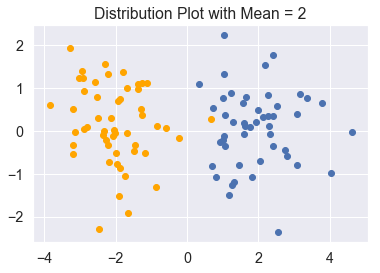

In [13]:
import numpy as np

def get_multivariate_sample(n, d, mean):
    x_sample = []
    y_sample = []
    means = np.zeros(d)
    means[0] = mean
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.multivariate_normal(-means, np.identity(d))
        else:
            x = np.random.multivariate_normal(means, np.identity(d))
        x_sample.append(x.tolist())
        y_sample.append(y)
    return x_sample, y_sample

import matplotlib.pyplot as plt

def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_multivariate_sample(100, 2, 2)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
plt.scatter([x[0] for x in list(zip(*class_one))[0]], [x[1] for x in list(zip(*class_one))[0]], c = 'b')
plt.scatter([x[0] for x in list(zip(*class_neg_one))[0]], [x[1] for x in list(zip(*class_neg_one))[0]], c = 'orange')
plt.title("Distribution Plot with Mean = 2")
plt.show()

In [14]:
X, y = get_multivariate_sample(100, 2, 1)
estimate_x_params(X)

(array([[-0.22476723,  0.98306512],
        [-0.18649446, -0.38599267]]), array([[[ 1.57082944, -0.01301811],
         [-0.01301811,  0.77251205]],
 
        [[ 1.56240101,  0.01635323],
         [ 0.01635323,  0.47795426]]]))

In [15]:
#def multi_normal_entropy(x1, x2, mean, covar):
#    return multivariate_normal.pdf([x1,x2], mean, covar)*np.log(multivariate_normal.pdf([x1,x2], mean, covar))

#integrate.nquad(multi_normal_entropy, [[-20, 20], [-20, 20]], args = (0, np.identity(2)))

def multivariate_normal_entropy(covar):
    covar = np.array(covar)
    dim = covar.shape[-1]
    return multivariate_normal(np.zeros(dim), covar).entropy()

def two_mixture_multivariate_normal_entropy_f(t1, t2, t3, t4, mean_1, mean_2, covar_1, covar_2):
    t = (t1, t2, t3, t4)
    return -.5*multivariate_normal.pdf(t, mean_1, covar_1)*np.log(.5*multivariate_normal.pdf(t, mean_1, covar_1) + .5*multivariate_normal.pdf(t, mean_2, covar_2)) - .5*multivariate_normal.pdf(t, mean_1, covar_1)*np.log(.5*multivariate_normal.pdf(t, mean_1, covar_1) + .5*multivariate_normal.pdf(t, mean_2, covar_2))

def two_mixture_multivariate_normal_entropy(mean_1, mean_2, covar_1, covar_2):
    dim = 1
    # to handle dimension errors
    try:
        dim = len(mean_1)
    except TypeError:
        pass
    bounds = [[-5, 5] for _ in range(dim)]
    return integrate.nquad(two_mixture_multivariate_normal_entropy_f, bounds, args = [mean_1, mean_2, covar_1, covar_2])

def plugin_estimate_cat_multi(X, y):
    y_param = estimate_p(y)
    x_params = estimate_x_params(X)
    print("integrating")
    h_y = -y_param*np.log(y_param) - (1 - y_param)*np.log(1 - y_param)
    h_x_cond_y = multivariate_normal_entropy(x_params[1][0])*.5 + multivariate_normal_entropy(x_params[1][1])*.5
    h_x = two_mixture_multivariate_normal_entropy(x_params[0][0], x_params[0][1], x_params[1][0], x_params[1][1])
    return h_y - h_x + h_x_cond_y

In [11]:
X, y = get_multivariate_sample(10000, 4, 1)
estimate_x_params(X)
plugin_estimate_cat_multi(X, y)

integrating


array([0.29961871, 6.3508492 ])

In [ ]:
#def multi_normal_entropy(x1, x2, mean, covar):
#    return multivariate_normal.pdf([x1,x2], mean, covar)*np.log(multivariate_normal.pdf([x1,x2], mean, covar))

#integrate.nquad(multi_normal_entropy, [[-20, 20], [-20, 20]], args = (0, np.identity(2)))

def multivariate_normal_entropy(covar):
    covar = np.array(covar)
    dim = covar.shape[-1]
    return multivariate_normal(np.zeros(dim), covar).entropy()

def two_mixture_multivariate_normal_entropy_f(t1, t2, t3, t4, t5, mean_1, mean_2, covar_1, covar_2):
    t = (t1, t2, t3, t4, t5)
    return -.5*multivariate_normal.pdf(t, mean_1, covar_1)*np.log(.5*multivariate_normal.pdf(t, mean_1, covar_1) + .5*multivariate_normal.pdf(t, mean_2, covar_2)) - .5*multivariate_normal.pdf(t, mean_1, covar_1)*np.log(.5*multivariate_normal.pdf(t, mean_1, covar_1) + .5*multivariate_normal.pdf(t, mean_2, covar_2))

def two_mixture_multivariate_normal_entropy(mean_1, mean_2, covar_1, covar_2):
    dim = 1
    # to handle dimension errors
    try:
        dim = len(mean_1)
    except TypeError:
        pass
    bounds = [[-5, 5] for _ in range(dim)]
    return integrate.nquad(two_mixture_multivariate_normal_entropy_f, bounds, args = [mean_1, mean_2, covar_1, covar_2])

def plugin_estimate_cat_multi(X, y):
    y_param = estimate_p(y)
    x_params = estimate_x_params(X)
    print("integrating")
    h_y = -y_param*np.log(y_param) - (1 - y_param)*np.log(1 - y_param)
    h_x_cond_y = multivariate_normal_entropy(x_params[1][0])*.5 + multivariate_normal_entropy(x_params[1][1])*.5
    h_x = two_mixture_multivariate_normal_entropy(x_params[0][0], x_params[0][1], x_params[1][0], x_params[1][1])
    return h_y - h_x + h_x_cond_y

X, y = get_multivariate_sample(10000, 5, 1)
estimate_x_params(X)
plugin_estimate_cat_multi(X, y)

integrating


In [ ]:
#def multi_normal_entropy(x1, x2, mean, covar):
#    return multivariate_normal.pdf([x1,x2], mean, covar)*np.log(multivariate_normal.pdf([x1,x2], mean, covar))

#integrate.nquad(multi_normal_entropy, [[-20, 20], [-20, 20]], args = (0, np.identity(2)))

def multivariate_normal_entropy(covar):
    covar = np.array(covar)
    dim = covar.shape[-1]
    return multivariate_normal(np.zeros(dim), covar).entropy()

def two_mixture_multivariate_normal_entropy_f(t1, t2, t3, t4, t5, t6, t7, t8, mean_1, mean_2, covar_1, covar_2):
    t = (t1, t2, t3, t4, t5, t6, t7, t8)
    return -.5*multivariate_normal.pdf(t, mean_1, covar_1)*np.log(.5*multivariate_normal.pdf(t, mean_1, covar_1) + .5*multivariate_normal.pdf(t, mean_2, covar_2)) - .5*multivariate_normal.pdf(t, mean_1, covar_1)*np.log(.5*multivariate_normal.pdf(t, mean_1, covar_1) + .5*multivariate_normal.pdf(t, mean_2, covar_2))

def two_mixture_multivariate_normal_entropy(mean_1, mean_2, covar_1, covar_2):
    dim = 1
    # to handle dimension errors
    try:
        dim = len(mean_1)
    except TypeError:
        pass
    bounds = [[-5, 5] for _ in range(dim)]
    return integrate.nquad(two_mixture_multivariate_normal_entropy_f, bounds, args = [mean_1, mean_2, covar_1, covar_2])

def plugin_estimate_cat_multi(X, y):
    y_param = estimate_p(y)
    x_params = estimate_x_params(X)
    print("integrating")
    h_y = -y_param*np.log(y_param) - (1 - y_param)*np.log(1 - y_param)
    h_x_cond_y = multivariate_normal_entropy(x_params[1][0])*.5 + multivariate_normal_entropy(x_params[1][1])*.5
    h_x = two_mixture_multivariate_normal_entropy(x_params[0][0], x_params[0][1], x_params[1][0], x_params[1][1])
    return h_y - h_x + h_x_cond_y

X, y = get_multivariate_sample(10000, 8, 1)
estimate_x_params(X)
plugin_estimate_cat_multi(X, y)

In [35]:
#def multi_normal_entropy(x1, x2, mean, covar):
#    return multivariate_normal.pdf([x1,x2], mean, covar)*np.log(multivariate_normal.pdf([x1,x2], mean, covar))

#integrate.nquad(multi_normal_entropy, [[-20, 20], [-20, 20]], args = (0, np.identity(2)))

def multivariate_normal_entropy(covar):
    covar = np.array(covar)
    dim = covar.shape[-1]
    return multivariate_normal(np.zeros(dim), covar).entropy()

def two_mixture_multivariate_normal_entropy_f(t1, t2, mean_1, mean_2, covar_1, covar_2):
    t = (t1, t2)
    return -.5*multivariate_normal.pdf(t, mean_1, covar_1)*np.log(.5*multivariate_normal.pdf(t, mean_1, covar_1) + .5*multivariate_normal.pdf(t, mean_2, covar_2)) - .5*multivariate_normal.pdf(t, mean_2, covar_2)*np.log(.5*multivariate_normal.pdf(t, mean_1, covar_1) + .5*multivariate_normal.pdf(t, mean_2, covar_2))

def two_mixture_multivariate_normal_entropy(mean_1, mean_2, covar_1, covar_2):
    dim = 1
    # to handle dimension errors
    try:
        dim = len(mean_1)
    except TypeError:
        pass
    bounds = [[-10, 10] for _ in range(dim)]
    return integrate.nquad(two_mixture_multivariate_normal_entropy_f, bounds, args = [mean_1, mean_2, covar_1, covar_2])

def plugin_estimate_cat_multi(X, y):
    y_param = estimate_p(y)
    x_params = estimate_x_params(X)
    print("integrating")
    h_y = -y_param*np.log(y_param) - (1 - y_param)*np.log(1 - y_param)
    h_x_cond_y = multivariate_normal_entropy(x_params[1][0])*.5 + multivariate_normal_entropy(x_params[1][1])*.5
    h_x = two_mixture_multivariate_normal_entropy(x_params[0][0], x_params[0][1], x_params[1][0], x_params[1][1])
    return h_y - h_x + h_x_cond_y

X, y = get_multivariate_sample(10000, 2, 1)
estimate_x_params(X)
plugin_estimate_cat_multi(X, y)

integrating


array([0.32172777, 3.48004234])

In [36]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = get_sample(1000, 0, 1)
X = np.array(X).reshape(-1, 1)

def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .32, bootstrap = True, depth = 30, min_samples_leaf = 1):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = min_samples_leaf), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        
        total_unsampled = len(unsampled_indices)
        np.random.shuffle(unsampled_indices)
        prob_indices, eval_indices = unsampled_indices[:total_unsampled//2], unsampled_indices[total_unsampled//2:]
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get probs for eval samples
        posterior_class_counts = np.zeros((len(node_counts), model.n_classes_))
        for prob_index in prob_indices:
            posterior_class_counts[tree.apply(X[prob_index].item()).item(), y[prob_index]] += 1
        row_sums = posterior_class_counts.sum(axis=1)
        row_sums[row_sums == 0] = 1
        class_probs = (posterior_class_counts/row_sums[:, None])
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1/(2*row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1/(2*row_sums[elem[0], None])
        class_probs.tolist()
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[eval_indices])])
        # get probability for out of bag samples
        eval_class_probs = [class_probs[x] for x in tree.apply(X[eval_indices])]
        eval_class_probs = np.array(eval_class_probs)
        # find total elements for out of bag samples
        elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[eval_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

rf_entropy_estimate_bagging(X, y, 500, .32)


/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


0.6826752373237107

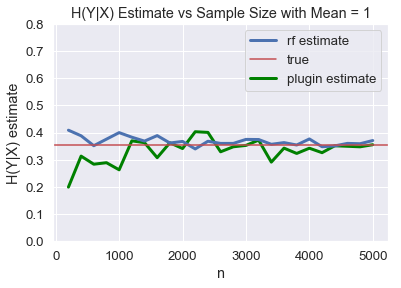

In [63]:
from tqdm import tqdm_notebook
def get_cond_entropy_vs_n(mean):
    conditional_entropy = []
    plugin_estimate = []
    sample_sizes = [i*200 for i in range(1, 26)]
    for elem in tqdm_notebook(sample_sizes):
        X, y = get_sample(elem, mean, 1)
        conditional_entropy.append(rf_entropy_estimate_bagging(np.array(X).reshape(-1, 1), y, 300, .32, depth = 30))
        plugin_estimate.append(plugin_estimate_cat_1D(np.array(X).reshape(-1, 1), y).item())
    return sample_sizes, conditional_entropy, plugin_estimate

#sample_sizes, cond_entropy, plugin_estimate = get_cond_entropy_vs_n(1)
#plt.scatter(sample_sizes, cond_entropy, marker = "None",)
#plt.scatter(sample_sizes, plugin_estimate, marker = "None")
sns.set(font_scale = 1.2)
line_plugin, = plt.plot(sample_sizes, plugin_estimate, label = "plugin estimate", linewidth = 3, color = "green")
line_est, = plt.plot(sample_sizes, cond_entropy, label = "rf estimate", linewidth = 3)
line_true = plt.axhline(y=.356, color='r', linestyle='-', label = "true")
plt.xlabel("n")
plt.ylabel("H(Y|X) estimate")
plt.ylim(ymin = 0)
plt.ylim(ymax = .8)
plt.legend(handles=[line_est, line_true, line_plugin])
plt.title("H(Y|X) Estimate vs Sample Size with Mean = 1")
plt.show()